# Behavioral Cloning

Files Included:-
>* drive.py : unchanged
>* model.py : code explained in Writeup.html and Writeup.md
>* model.h5 : trained model
>* Preprocessing.ipynb : contains visualisations of data, its preprocessing functions and model
>* Writeup.html : contains html of PreProcessing.ipynb which has all the code and explanation
>* Writeup.mdl: inside writeup folder
>* Video.mp4: track-1 output [youtube: https://youtu.be/cSj_D0hhO7w]

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2
from IPython.display import display 
%matplotlib inline

In [7]:
columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv('./data/driving_log.csv', names=columns)

## Data Exploration

* In the histogram that follows we can see that the data is biased very highly towards center steering angles
* To get a more balanced dataset we need to augment the images with higher steering angles
* Augmentation functions are displayed further below along with their outputs

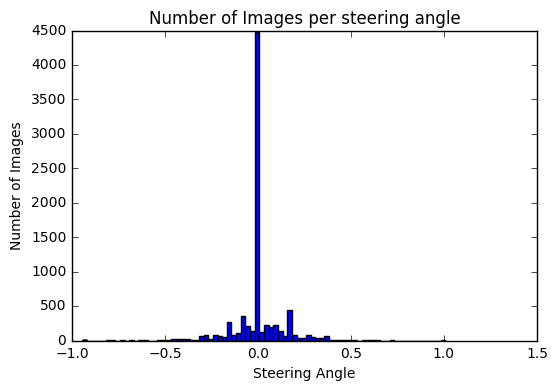

In [8]:
binwidth = 0.025
a = np.array(data.steering_angle[1:]).astype(np.float)
plt.hist(a,bins=np.arange(min(a), max(a) + binwidth, binwidth))
plt.title('Number of Images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('Number of Images')
plt.show()

### Reading data and train test split

* data is read and train test split of 80-20 is done initially
* the training data is further augmented on the fly by the generators defined further below

In [4]:
import numpy as np
import csv
import cv2
import sys

car_images = []
steering_angles = []
path = './data/IMG/'
csv_file = './data/driving_log.csv'
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        steering_center = float(row[3])

        correction = 0.2 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        img_center = path+row[0].split('/')[-1]
        img_left   = path+row[1].split('/')[-1]
        img_right  = path+row[2].split('/')[-1]

        car_images = car_images + [img_center, img_left, img_right]
        steering_angles = steering_angles + [steering_center, steering_left, steering_right] 

X_train = car_images
y_train = np.array(steering_angles)
samples = list(zip(X_train, y_train))

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

### Data Augmentation

#### 1) Using Left and Right Camera Images
* Use images from all cameras (center, left and right), by adding a certain correction factor (here 0.2) to the left and right image to generate a high steering angle datapoint

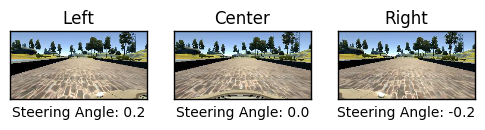

In [5]:
import matplotlib.image as mpimg

c,l,r = mpimg.imread(X_train[0]), mpimg.imread(X_train[1]), mpimg.imread(X_train[2])
ac,al,ar = y_train[0], y_train[1], y_train[2]

plt.subplot(1,3,1)
plt.imshow(l)
plt.title('Left')
plt.yticks([])
plt.xticks([])
plt.xlabel('Steering Angle: ' + str(al))

plt.subplot(1,3,3)
plt.imshow(r)
plt.title('Right')
plt.yticks([])
plt.xticks([])
plt.xlabel('Steering Angle: ' + str(ar))

plt.subplot(1,3,2)
plt.imshow(c)
plt.title('Center')
plt.yticks([])
plt.xticks([])
plt.xlabel('Steering Angle: ' + str(ac))

In [6]:
import matplotlib.image as mpimg
img = mpimg.imread(X_train[400])
angle = y_train[400]

### 2) Horizontally flipping the images
* Flip the image horizontally and invert the corresponding steering angle to get more samples of higher steering angles

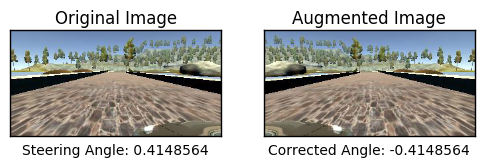

In [7]:
# flip images horizontally
def horizontal_flip(img, steering_angle):
    flipped_image = cv2.flip(img, 1)
    steering_angle = -1 * steering_angle
    return flipped_image, steering_angle

a_img, a_angle = horizontal_flip(img, angle)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.yticks([])
plt.xticks([])
plt.xlabel('Steering Angle: ' + str(angle))

plt.subplot(1,2,2)
plt.imshow(a_img)
plt.title('Augmented Image')
plt.yticks([])
plt.xticks([])
plt.xlabel('Corrected Angle: ' + str(a_angle))

### 3) Horizontally shifting the image
* The images are horizontally shifted and the angle is obtained after a transformation to generate more samples

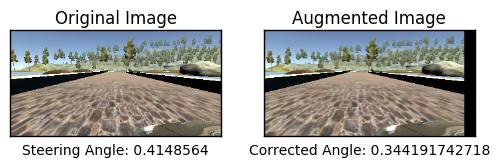

In [8]:
#horizontally shift image by some pixels
WIDTH_SHIFT_RANGE = 100
def horiz_shift(img, steering_angle):
    rows, cols, channels = img.shape
    
    # Translation
    #* idea borrowed from attributions
    tx = WIDTH_SHIFT_RANGE * np.random.uniform() - WIDTH_SHIFT_RANGE / 2
    ty = 0
    steering_angle = steering_angle + tx / WIDTH_SHIFT_RANGE * 2 * .2
    
    transform_matrix = np.float32([[1, 0, tx],
                                   [0, 1, ty]])
    
    translated_image = cv2.warpAffine(img, transform_matrix, (cols, rows))
    return translated_image, steering_angle

a_img, a_angle = horiz_shift(img, angle)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.yticks([])
plt.xticks([])
plt.xlabel('Steering Angle: ' + str(angle))

plt.subplot(1,2,2)
plt.imshow(a_img)
plt.title('Augmented Image')
plt.yticks([])
plt.xticks([])
plt.xlabel('Corrected Angle: ' + str(a_angle))

### 4) Change image brightness
* Image brightness is changed randomly so that the model gets samples which have a certain shadow or light component in them
* this helps model generalise of shadows and changing lighting conditions

([], <a list of 0 Text xticklabel objects>)

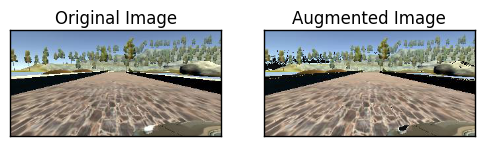

In [9]:
#shift the brightness of the images
def brightness_shift(img, bright_value=None):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if bright_value:
        img[:,:,2] += bright_value
    else:
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

a_img = brightness_shift(img)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.yticks([])
plt.xticks([])

plt.subplot(1,2,2)
plt.imshow(a_img)
plt.title('Augmented Image')
plt.yticks([])
plt.xticks([])

### This function is used to randomply apply any of the above transformations to the image in the generator

In [10]:
def randomly_apply_transformation(img, angle):
    i = np.random.randint(3)
    if (i == 0):
        a_img = brightness_shift(img)
        a_angle = angle
    elif (i == 1):
        a_img, a_angle = horiz_shift(img,angle)
    elif (i == 2):
        a_img, a_angle = horizontal_flip(img,angle)
    return a_img, a_angle

### The generator used to get images while training
* In the generator, some logic is implemented so that the number of samples with low steering values going to the model for training is reduced 
* Explanation is in the code below

In [11]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                image = mpimg.imread(batch_sample[0])
                angle = batch_sample[1]
                
                #* idea borrowed from attributions
                keep = 0
                while keep == 0:
                    x, y = randomly_apply_transformation(image, angle)
                    if abs(y) < .1:
                        val = np.random.uniform()
                        #(val>threshold) 0.4 ensures that probability of getting lower steering data is about 0.6 
                        #as val comes from a uniform distribution
                        if val > 0.4: 
                            keep = 1
                    else:
                        keep = 1
                
                
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

* following is the generator used for validation
* generator used for validation does not have same functionality as training generator
* It just gives out images from the validation set without any augmentation, as we need to check validation accuracy on the raw available validation data

In [12]:
## Image generator
import numpy as np
import cv2
import sklearn
import random
import matplotlib.image as mpimg

def generator_default(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                image = mpimg.imread(batch_sample[0])
                angle = batch_sample[1]
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator_default(validation_samples, batch_size=32)

print((next(train_generator)[0]).shape)

(32, 160, 320, 3)


### Model Architecture

I started my experiment with the Nvidia's SDC architecture described in:- http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

It consists of:-
* 5 convolutional layers
* 3 fully connected layers

Pipeline is as follows:-

>* input image 160,320,3
>* Lamba layer for resizing to 132,300,3
>* Lambda layer for cropping upper and lower parts (sky and car's hood) final input = 66,200,3
>* conv filter 24x5x5 
>* Dropout
>* conv filter 36x5x5
>* Dropout
>* conv filter 48x5x5
>* Dropout
>* conv filter 64x3x3
>* Dropout
>* conv filter 64x3x3
>* Dropout
>* 100
>* Dropout
>* 50
>* 10
>* Dropout
>* output

* Batch size used = 64
* images per epoch = 24000
* number of epochs = 12
* Optimizer used = Adam
* MSE error function was used for optimization
* default learning rate was used for Adam optimizer
* dropouts were used to help model generalize more from the provided dataset

In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Convolution2D, MaxPooling2D, Cropping2D, SpatialDropout2D

import tensorflow as tf

def resize_inpt(img):
    import tensorflow as tf
    #return tf.image.resize_images(img, (120, 200))
    return tf.image.resize_images(img, (132, 200))


model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Lambda(resize_inpt, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((33,17),(0,0))))

model.add(Convolution2D(24,5,5,subsample=(2,2), activation="relu"))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation="relu"))
model.add(SpatialDropout2D(0.4))
model.add(Convolution2D(48,5,5,subsample=(2,2), activation="relu"))
model.add(SpatialDropout2D(0.3))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(SpatialDropout2D(0.2))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(SpatialDropout2D(0.1))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
number_of_epochs=12
samples_per_epoch=24000
model.fit_generator(train_generator, samples_per_epoch=samples_per_epoch, validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=number_of_epochs)
#model.save('model_temp_9_4.h5')

Using TensorFlow backend.


### Track-1 Video Link 
* Track-1>> https://youtu.be/cSj_D0hhO7w

### Discussion:-

* The provided model is trained with default adam optimizer with 0.01 learning rate, which gves some convergence after 7 epochs and an oscillating validation error after aound 12 epochs (convergence after 7-8 epochs is sufficient enough for model to drive multiple laps on track one without going off track, but for track two it needs more training) 
* (epochs were kept less because training was very slow for single instance gpu which I used, will try to improve upon that soon)

#### Experiments yet to be done:-
* use vertical shift augmentation to get images with changing height terrain to train the model for variations in road level
* generate images with high shear to simulate hard turns, and improve the model for sharp turns
* genrate more training data using joystick for sharper turns and use it to train
* run model for longer epochs with lower learning rate (0.001) to get even better generalizaion and convergence

##### Attributions:-
https://srikanthpagadala.github.io/serve/carnd-behavioral-cloning-p3-report.html

Srikanths report helped me with:-
* 1) get the idea of randomly skipping the data with low steering angle, on the fly in the generator. [lines marked with * in the generator] 
* 2) And also the helped tune the horizontal shift steering angle transformation.